###Import data from kaggle


In [ ]:
!pip install -U -q kaggle --force
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c nnfl-lab-1
!cd /content
!unzip nnfl-lab-1.zip

In [ ]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras import optimizers
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

np.random.seed(0)
random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)


print(os.listdir("../content"))

['.config', 'sample_sub.csv', 'training', 'nnfl-lab-1.zip', 'kaggle.json', 'submission.csv', 'testing', 'model.h5', 'sample_data']


In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=32

###Data

In [ ]:
filenames = os.listdir("../content/training/training")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

###Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../content/training/training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size
)

Found 4160 validated image filenames belonging to 4 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../content/training/training", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size
)

Found 1040 validated image filenames belonging to 4 classes.


###Callbacks
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

###Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu')) #32
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), bias_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax')) # 2 because we have cat and dog classes

opt = optimizers.Adam(learning_rate=0.01) #'rmsprop'
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

###Fit Model

In [ ]:
tf.random.set_seed(0)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

epochs=30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

model.save_weights("model.h5")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
 60/130 [============>.................] - ETA: 27s - loss: 2.0954 - accuracy: 0.5286

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


130/130 [==============================] - 61s 467ms/step - loss: 1.5900 - accuracy: 0.5851 - val_loss: 4.9124 - val_accuracy: 0.3301
Epoch 2/30
130/130 [==============================] - 60s 463ms/step - loss: 1.0126 - accuracy: 0.6894 - val_loss: 1.1430 - val_accuracy: 0.6406
Epoch 3/30
130/130 [==============================] - 60s 464ms/step - loss: 0.9050 - accuracy: 0.7269 - val_loss: 1.0957 - val_accuracy: 0.6816
Epoch 4/30
130/130 [==============================] - 60s 464ms/step - loss: 0.8413 - accuracy: 0.7474 - val_loss: 1.6473 - val_accuracy: 0.5420
Epoch 5/30
130/130 [==============================] - 60s 460ms/step - loss: 0.8176 - accuracy: 0.7553 - val_loss: 0.8883 - val_accuracy: 0.7227
Epoch 6/30
130/130 [==============================] - 60s 464ms/step - loss: 0.7263 - accuracy: 0.7808 - val_loss: 1.0894 - val_accuracy: 0.6738
Epoch 7/30
130/130 [==============================] - 60s 460ms/step - loss: 0.7073 - accuracy: 0.7986 - val_loss: 0.6973 - val_accuracy: 0.7

##Visualise Training

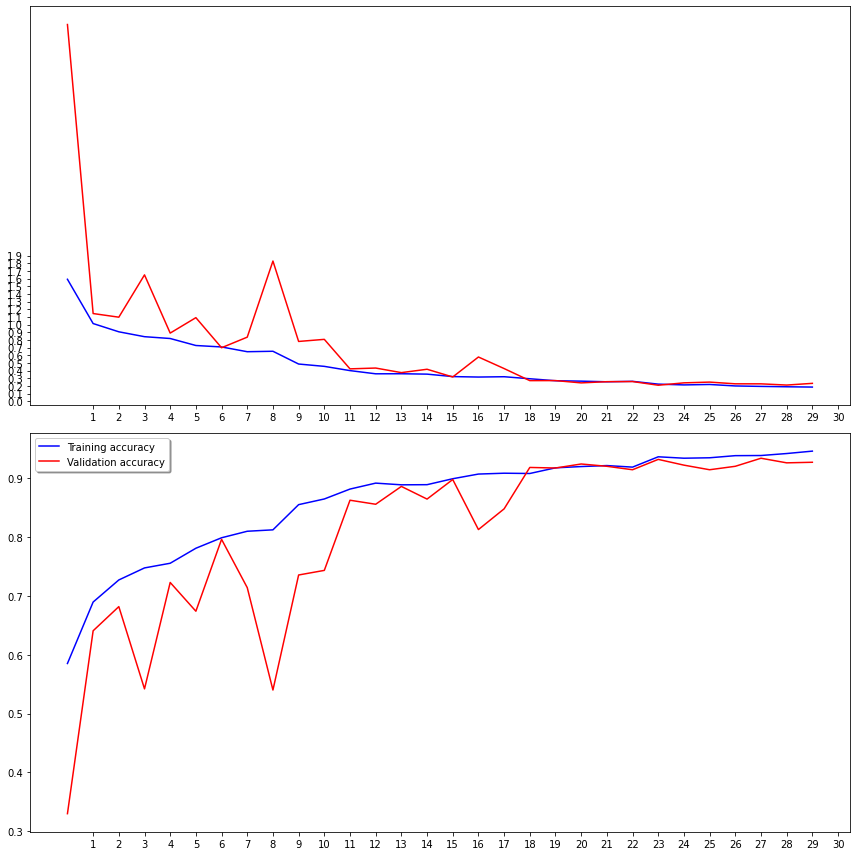

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs+1, 1))
ax1.set_yticks(np.arange(0, 2, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs+1, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir("../content/testing/testing/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../content/testing/testing", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1267 validated image filenames.


In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


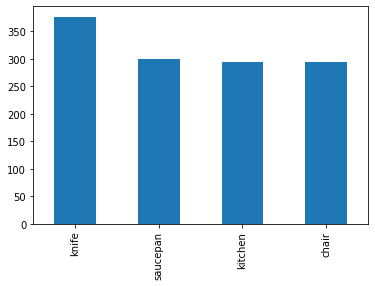

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'].value_counts().plot.bar()

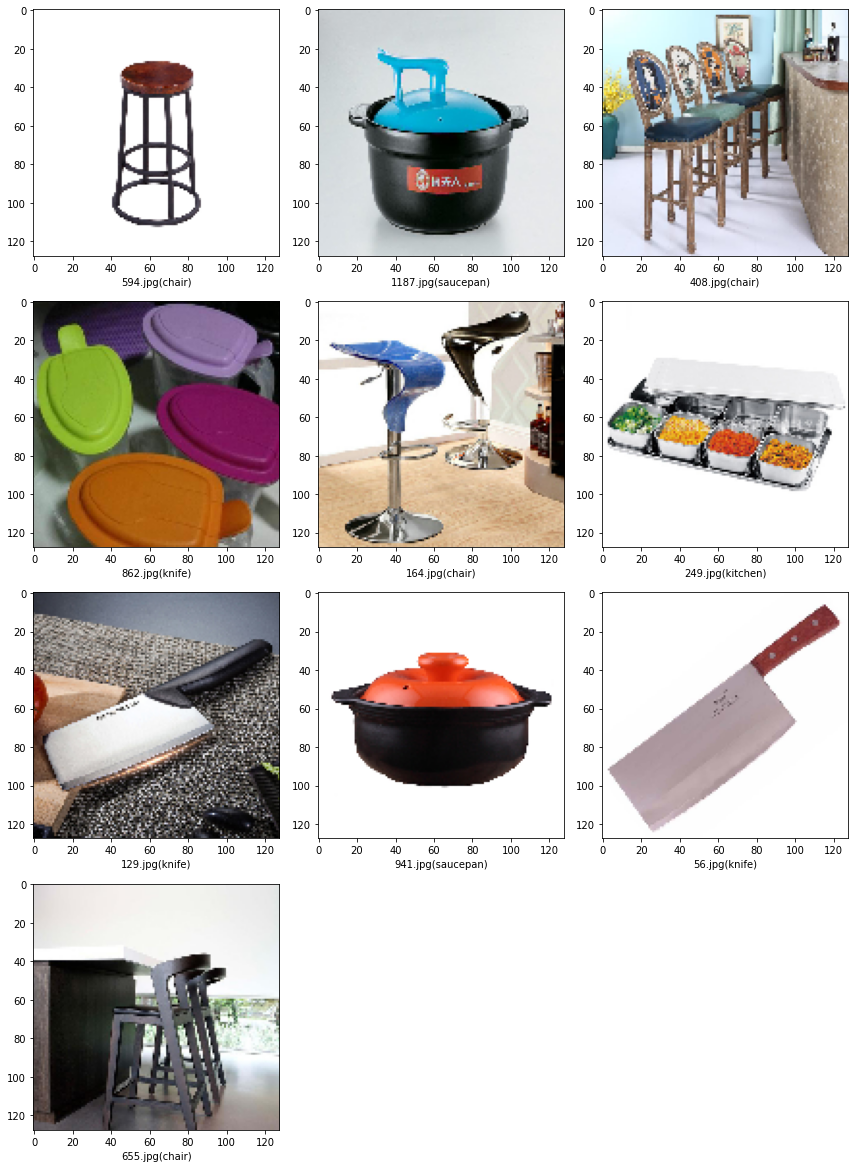

In [ ]:
sample_test = test_df.head(10)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/testing/testing/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
test_df['category'] = test_df['category'].replace({'chair' : 0, 'kitchen' : 1, 'knife' : 2, 'saucepan' : 3})

submission_df = test_df.copy()
submission_df['id'] = submission_df['filename']
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)